In [1]:
# Basics
import numpy as np
import os 
import pandas as pd

# Image Loading
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
%matplotlib inline

# Evaluation
from sklearn import metrics

# Data preprocessing
from sklearn.preprocessing import normalize, StandardScaler

# Dimensionality Reduction
from sklearn.manifold import TSNE                   # 1) T-SNE
from sklearn.decomposition import PCA               # 2) PCA

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model


Using TensorFlow backend.


In [2]:
## Data loading, and standardizing

trainData = "../Data/train" # 10k images //  96 x 96 x 3


new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename)) 
        new_train.append(np.asarray( image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train)
X = meanMatrix.reshape((len(new_train),-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [3]:
def ClusterAndPlot(n_clusters):
    Labels = []
    
    print(X.shape)
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit(X)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(X, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(X, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X)
    gmmlabels_ = gmm.predict(X)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(X, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(X[:, 0], X[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(X[:, 0], X[:, 1], c=gmmlabels_, cmap='viridis')
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(X[:, 0], X[:, 1], c=HC.labels_, cmap='viridis')
    axs[1, 1].set_title('HC')
    plt.show()
    
    Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
    Labels.append(gmmlabels_)
    return Labels


In [4]:
def pltPathologyClusters(labels):
    clusterimgDir = "../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (80,10))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    
    for cluster in sub_directories:
        direct = trainData + '/{}'.format(cluster)
        index = np.random.randint(0,len(os.listdir(direct)))
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                image = Image.open(os.path.join(direct, file)) 
                displayImages.append(np.asarray( image, dtype="uint8" ))
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(columns*rows+1)
    j = 0
    for i in range(1, columns*rows+1):
        img = displayImages[j]
        j+=1
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.text(rows, columns, "ss")
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()
    


In [5]:
n_images = X.shape[0]
X.shape

(9999, 27648)

In [6]:
# STEP 1 : Cluster on the full dimensional space

In [7]:
# STEP 2 : Reduce the full dimensional space using PCA & t-SNE -> Cluster

(9999, 27648)
(9999, 50)
(9999, 2)


Text(0.5, 1.0, 'TSNE')

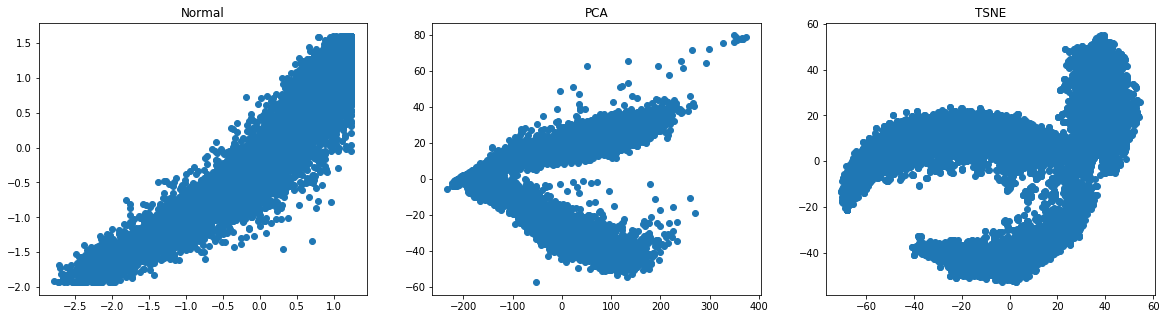

In [8]:
# reduce dimensions then cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
print(X.shape)
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[0].set_title('Normal')

# PCA 
pca = PCA(n_components=50)
X = pca.fit_transform(X)
print(X.shape)

axs[1].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[1].set_title('PCA')

tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)
print(X2.shape)

axs[2].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[2].set_title('TSNE')

In [ ]:
Labels = ClusterAndPlot(9)

(9999, 27648)


In [ ]:
# Step 3: Reduce the full dimensional space using autoencoders -> Cluster
meanMatrix.shape

In [ ]:
# autoencoder = load_model('Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16
# autoencoder = load_model('Autoencoders/SavedModels/autoencoder_train_epochs100_batch32_best.h5') # 6 x 6 x 32
autoencoder = load_model('Autoencoders/SavedModels/mean_squared_error_epochs300_batch64.h5') # Regression with 32
autoencoder.summary()

In [ ]:
# Evaluate regression
csvFilePath = "../Data/regrData/train_labels.csv"
df = pd.read_csv(csvFilePath)
testlabels = []

for image in image_names:
    label_index = df[df["id"] == image.split(".")[0]].index[0]
    testlabels.append(df["label"][label_index])
    
def evaluateRegression():
    labels_pred = autoencoder.predict(meanMatrix)[1]
    for i in range(len(labels_pred)):
        if labels_pred[i] < 0.5:
            labels_pred[i] = 0
        else:
            labels_pred[i] = 1

    evaluation = metrics.classification_report(testlabels, labels_pred)
    print(evaluation)


In [ ]:
evaluateRegression()

In [ ]:
layer_name = 'conv2d_115'
intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[0].set_title('Normal')

X = X.reshape((n_images, -1))
print(X.shape)
axs[1].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[1].set_title('Normal Reshaped')

In [ ]:
Labels = ClusterAndPlot(9)

In [ ]:
pltPathologyClusters(Labels[1])

In [ ]:
# STEP 4: Reduce the full dimensional space using autoencoders -> PCA&t-SNE -> Cluster

In [ ]:
# reduce dimensions then cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
print(X.shape)
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[0].set_title('Normal')

# # PCA 
# pca = PCA(n_components=50)
# X = pca.fit_transform(X)
# print(X.shape)

# axs[1].scatter(X[:, 0], X[:, 1], cmap='viridis');
# axs[1].set_title('PCA')

tsne = TSNE(n_components=2, perplexity=350)
X = tsne.fit_transform(X)
print(X.shape)

axs[2].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[2].set_title('TSNE')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7))

tsne1 = TSNE(n_components=2, perplexity=5)
tsne1data = tsne.fit_transform(X)

axs[0, 0].scatter(tsne1data[:, 0], tsne1data[:, 1], cmap='viridis');
axs[0, 0].set_title('tsne1data')

tsne2 = TSNE(n_components=2, perplexity=15)
tsne2data = tsne.fit_transform(X)

axs[0, 1].scatter(tsne2data[:, 0], tsne2data[:, 1], cmap='viridis');
axs[0, 1].set_title('tsne2data')

tsne3 = TSNE(n_components=2, perplexity=30)
tsne3data = tsne.fit_transform(X)

axs[1, 0].scatter(tsne3data[:, 0], tsne3data[:, 1], cmap='viridis');
axs[1, 0].set_title('tsne3data')

tsne4 = TSNE(n_components=2, perplexity=50)
tsne4data = tsne.fit_transform(X)

axs[1, 1].scatter(tsne4data[:, 0], tsne4data[:, 1], cmap='viridis');
axs[1, 1].set_title('tsne4data')

In [ ]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])

kmeans = KMeans(n_clusters=9, random_state=0).fit(X)
# clusterintoDirectories(HC.labels_)
clusterintoDirectories(kmeans.labels_)
# clusterintoDirectories(gmmlabels_)